In [1]:
import json
import os
import time

import matplotlib.pylab as plt
import numpy as np
import tqdm

In [2]:
MODEL_DIR = "/home/john/pytorch_image_classification/results/cifar_search"
LOG = "log.json"
PREDICTIONS = "predictions_{}.npy"

In [3]:
def is_valid(name):
    if not os.path.isfile(os.path.join(MODEL_DIR, name, LOG)):
        return False
    return True
    
# Filter out failed runs
model_names = [name for name in os.listdir(MODEL_DIR) if is_valid(name)]

How good are the models we're training?

In [4]:
def best_test(name):
    with open(os.path.join(MODEL_DIR, name, LOG)) as handle:
        log = json.load(handle)
    return max([epoch["test"]["accuracy"] for epoch in log])

In [5]:
test_accs = [best_test(name) for name in model_names]

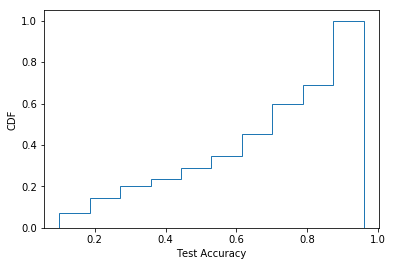

In [6]:
plt.hist(test_accs, cumulative=True, label='CDF', density=True, histtype='step')
plt.xlabel("Test Accuracy")
plt.ylabel("CDF")
plt.show()

Compute similarities for all of the models

In [23]:
answers = np.load("testvecs.npy")

In [24]:
# Models all trained for 200 epochs. Take 10 checkpoints during training
checkpoints = list(range(0, 201, 20))

predictions = []
for name in model_names:
    for checkpoint in checkpoints:
        fname = os.path.join(MODEL_DIR, name, PREDICTIONS.format(checkpoint))
        if not os.path.isfile(fname):
            continue
        with open(fname, "rb") as handle:
            preds = np.load(handle)
        predictions.append(preds)

In [25]:
def multiclass_simularity(i, j):
    return np.mean(predictions[i] == predictions[j])

def correct_simularity(i, j):
    return np.mean((predictions[i] == answers) == (predictions[j] == answers))

mc_sims = []
corr_sims = []
for i in tqdm.tqdm_notebook(range(len(predictions))):
    for j in range(i + 1, len(predictions)):
        mc_sims.append(multiclass_simularity(i, j))
        corr_sims.append(correct_simularity(i, j))

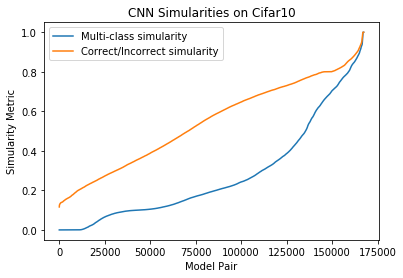

In [26]:
# Plot similarities!
plt.plot(sorted(mc_sims), label="Multi-class simularity")
plt.plot(sorted(corr_sims), label="Correct/Incorrect simularity")
plt.title("CNN Simularities on Cifar10")
plt.xlabel("Model Pair")
plt.ylabel("Simularity Metric")
plt.legend()
plt.show()

In [27]:
# Refine the analyis by bucketing using errors
errors = [np.mean(preds == answers) for preds in predictions]

In [28]:
gap = 0.05
valid_pairs = []
for i in range(len(predictions)):
    for j in range(len(predictions)):
        if np.abs(errors[i] - errors[j]) < gap:
            valid_pairs.append((i, j))

In [29]:
mc_sims = []
corr_sims = []
for (i, j) in tqdm.tqdm_notebook(valid_pairs):
    mc_sims.append(multiclass_simularity(i, j))
    corr_sims.append(correct_simularity(i, j))

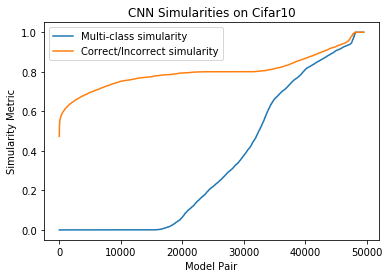

In [30]:
# Plot similarities!
plt.plot(sorted(mc_sims), label="Multi-class simularity")
plt.plot(sorted(corr_sims), label="Correct/Incorrect simularity")
plt.title("CNN Simularities on Cifar10")
plt.xlabel("Model Pair")
plt.ylabel("Simularity Metric")
plt.legend()
plt.show()